In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Deutsch-Jozsa Problem

We are given a hidden Boolean function f , which takes as input a string of bits, and returns either 0 or 1 , that is:

$$f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all 0 's or all 1 's for any input, while a balanced function returns 0 's for exactly half of all inputs and 1 's for the other half. Our task is to determine whether the given function is balanced or constant.

Note that the Deutsch-Jozsa problem is an n-bit extension of the single bit Deutsch problem.

### The Classical Solution

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function, f ( x ) , is balanced: e.g. if we get both f ( 0 , 0 , 0 , . . . ) → 0 and f ( 1 , 0 , 0 , . . . ) → 1 , then we know the function is balanced as we have obtained the two different outputs.

In the worst case, if we continue to see the same output for each input we try, we will have to check exactly half of all possible inputs plus one in order to be certain that f ( x ) is constant. Since the total number of possible inputs is 2 n , this implies that we need $2^{n − 1} + 1$ trial inputs to be certain that f ( x ) is constant in the worst case. For example, for a 4 -bit string, if we checked 8 out of the 16 possible combinations, getting all 0 's, it is still possible that the 9 th input returns a 1 and f ( x ) is balanced. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in succession, we can express the probability that the function is constant as a function of k inputs as:

$$P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad \textrm{for } 1 < k \leq 2^{n-1}$$

Realistically, we could opt to truncate our classical algorithm early, say if we were over x% confident. But if we want to be 100% confident, we would need to check $2^{n − 1} + 1$ inputs.

### The Quantum Solution

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function f ( x ), provided we have the function f implemented as a quantum oracle, which maps the state | x ⟩ | y ⟩ to | x ⟩ | y ⊕ f ( x ) ⟩ , where ⊕ is addition modulo 2 .

Now, let's go through the steps of the algorithm:

1- Prepare two quantum registers. The first is an n -qubit register initialized to | 0 ⟩ , and the second is a one-qubit register initialized to | 1 ⟩ :

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$

2- Apply a Hadamard gate to each qubit:

$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$

3- Apply the quantum oracle | x ⟩ | y ⟩ to | x ⟩ | y ⊕ f ( x ) ⟩ :

$$\begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
$$

since for each x , f ( x ) is either 0 or 1 .

4- At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register:

$$\begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}$$

where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.
Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to 1 if f ( x ) is constant and 0 if f ( x ) is balanced.

### Why does this work?

#### Constant Oracle

When the oracle is constant, it has no effect (up to a global phase) on the input qubits, and the quantum states before and after querying the oracle are the same. Since the H-gate is its own inverse, in Step 4 we reverse Step 2 to obtain the initial quantum state of | 00 … 0 ⟩ in the first register.

#### Balanced Oracle

After step 2, our input register is an equal superposition of all the states in the computational basis. When the oracle is balanced, phase kickback adds a negative phase to exactly half these states.
The quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, in Step 4, when applying the H-gates, we must end up with a quantum state that is orthogonal to | 00 … 0 ⟩ . This means we should never measure the all-zero state.


### Creating Quantum Oracles

Let's see some different ways we can create a quantum oracle.

For a constant function, it is simple:

1- if f(x) = 0, then apply the I gate to the qubit in register 2.

2- if f(x) = 1, then apply the X gate to the qubit in register 2.

For a balanced function, there are many different circuits we can create. 

One of the ways we can guarantee our circuit is balanced is by performing a CNOT for each qubit in register 1, with the qubit in register 2 as the target. 

## Qiskit Implementation

We will implement the Deutsch-Jozsa algorithm in Qiskit using a balanced oracle.

First we create our oracle which will give us a balanced output.

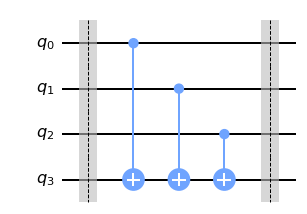

In [2]:
# set the length of the n-bit input string. 
n = 3

balanced_oracle = QuantumCircuit(n+1)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Show oracle
balanced_oracle.draw()


Now we apply the full algorithm.

/tmp/ipykernel_59/460382824.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


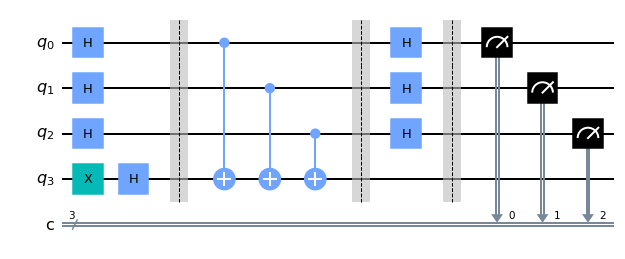

In [3]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

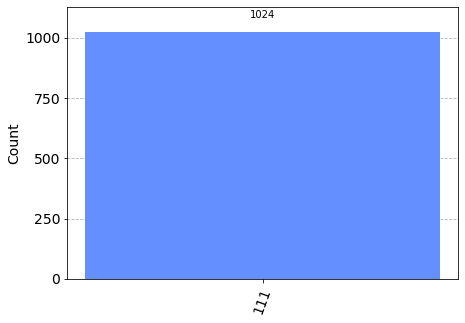

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


We can see from the results above that we have a 0% chance of measuring 000. This correctly predicts the function is balanced.